# HCCI Engine

This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 6 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 17 February 2020.

The objective of this tutorial is to show how to simulate an adiabatic homogeneous reactor with a specified time-varying volume using Cantera, and how this can be used to represent an idealized homogeneous-charge compression-ignition (HCCI) engine. More information on [Cantera zero-dimensional reactor networks](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html) is provided. We will use the thermodynamic properties and the reaction mechanism that are included in seiser.cti.

The file "seiser.cti" (provided with this Notebook) must be placed in a folder or directory named "data" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place. The .cti file is also available at https://github.com/Cantera/cantera-jupyter/tree/master/reactors/data.

The reader should be familiar with the material in the previous tutorial Notebook (6_1_Ignition_delay) before working through this Notebook.

## 1. Homogeneous-charge compression-ignition (HCCI) engines

In a homogeneous-charge compression-ignition (HCCI) engine, a nominally homogeneous fuel-air mixture is compressed to a temperature and pressure at which it autoignites. HCCI engines have the potential for higher efficiency and lower engine-out pollutant emissions compared to more conventional spark-ignition or diesel engines. The autoignition process depends on chemical kinetics that occur at relatively low temperatures, and is highly sensitive to small variations in mixture composition and temperature. A web search will bring up several sources of information: see https://en.wikipedia.org/wiki/Homogeneous_charge_compression_ignition, for example.

In fact, the in-cylinder mixture in a piston engine is never perfectly homogeneous. Even if one started with a spatially uniform temperature and composition at intake-value closure, the temperature would become nonhomogeneous during compression as a result of wall heat transfer. Nevertheless, as a first approximation we will assume that the in-cylinder mixture remains homogeneous through the compression, autoignition, and expansion process. Moreover, we will assume that there is no heat transfer to or from the surroundings: all processes are adiabatic. These simplifications allow us to build a relatively simple model for a HCCI engine using a [Cantera zero-dimensional reactor network](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html).

To accurately represent the autoignition process, a sufficiently detailed reaction mechanism is required. Here we will us the same n-heptane mechanism that was used in the previous tutorial Notebook.

## 2. Cantera model

We consider the time evolution of a closed (fixed-mass) homogeneous chemically reacting mixture with prescribed initial temperature, pressure, and composition, subjected to an imposed time-varying volume, and with no heat transfer to or from its surroundings (adiabatic). The governing equations for such a system are not presented explicitly in Chapter 6 of Turns 4th ed., but they can be readily derived following the approach that is shown there for a constant-pressure fixed-mass reactor and for a constant-volume fixed-mass reactor.

As was the case for the constant-volume and constant-pressure systems that were considered in earlier tutorial Notebooks, we do not need to explicitly provide the governing equations to solve the problem using Cantera. Rather, we build an appropriate model using tools that are available in Cantera zero-dimensional reactor networks. We can simulate a homogeneous fixed-mass reactor with a specified time-varying volume by adding one additional component to our reactor network, beyond what we have used in earlier tutorial Notebooks: a moving reactor wall, which we can use to prescribe the desired reactor volume as a function of time.

For this purpose, we use Cantera's [`Wall()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#wall) object. A wall is defined as an interface between two Cantera [`Reactor()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#reactor) objects (which we have seen earlier), or between one `Reactor()` object and one [`Reservoir()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#reservoir) object. A `Reservoir()` is essentially a `Reactor()` whose temperature, pressure, and composition remain fixed at their initial values.

Specifically, we define a `Reservoir()` that contains ambient air (the actual contents of the `Reservoir()` don't really matter, for our present purposes), an `IdealGasReactor()` that corresponds to the homogeneous gas mixture in the combustion chamber of a piston engine, and a `Wall()` (representing a moving piston) that separates the contents of the reservoir from those in the reactor. We prescribe initial conditions for the `Reactor()` that correspond to the in-cylinder mixture temperature, pressure, and composition at intake-valve closure, say. We then move the `Wall()` in a manner that causes the volume of the `Reactor()` to vary in time as desired, and we monitor the time evolution of the temperature, pressure, and composition of the gas mixture in the `IdealGasReactor()`. 

For appropriate choices of initial conditions (the intial `IdealGasReactor()` temperature, pressure, and composition) and the time-variation of volume, the system will autoignite in a manner that is representative of that in a HCCI engine. Here we consider n-heptane/air initial mixtures, using the same input data file that we used in the previous tutorial Notebook: seiser.cti. While wall heat transfer could be accommodated in principle in the reactor network model, here we will assume adiabatic walls.

Before moving to a reacting case that represents a HCCI engine, we consider a simpler nonreacting case, to show how the model is constructed and exercised.

## 3. Isentropic compression/expansion of a nonreacting gas mixture

We start with a case where negligible chemical reaction occurs: that is, where the mixture composition remains constant in time at the specified initial composition. Since the system is adiabatic and there are no irreversibilities, this corresponds to an isentropic compression/expansion process. For an ideal gas with constant specific heat ratio $ \gamma = c_p/c_v $, simple algebraic expressions can be derived that relate the temperature $T = T(t)$, pressure $P = P(t)$, and volume $V=V(t)$ of the system as it evolves in time $t$. For example:

$$ T V ^ {\gamma - 1} = constant, \ \ {\rm and} \ \ PV ^ {\gamma} = constant $$

Because we account for temperature-varying specific heats in our formulation (through the thermodynamic property data provided in the Cantera input data file), the value of $ \gamma $ does not remain exactly constant here, even in the absence of chemical reactions. We will compare the results obtained using a zero-dimensional reactor network with those obtained using the constant-$\gamma$ formulae (with an average value of $\gamma$) to see how accurate the constant-property approximation is for the case that is considered.

In [1]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import math # this provides access to some standard mathematical functions, using the prefix "math."

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define a gas mixture based on seiser.cti that corresponds to ambient air
# the file "seiser.cti" must be present in subdirectory "data" below the current working directory
ambair = ct.Solution('data/seiser.cti')

# specify the temperature, pressure, and composition
T_0 = 300.    # (K)
P_0 = 101325. # (Pa)
X_0 = {'o2':1.0, 'n2':3.76}

ambair.TPX = T_0, P_0, X_0

# print the thermochemical state of "ambair"
ambair()



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767

  gas:

       temperature             300  K
          pressure          101325  Pa
           density         1.17197  kg/m^3
  mean mol. weight         28.8507  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          1900.6        5.483e+04     J
   internal energy          -84556        -2.44e+06     J
           entropy            6891        1.988e+05     J/K
    Gibbs function     -2.0654e+06       -5.959e+07     J
 heat capacity c_p          1009.7        2.913e+04     J/K
 heat capacity c_v          721.46        2.081e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                n2       0.

In [3]:
# define a second gas mixture based on seiser.cti that corresponds to a n-heptane/air mixture
fuelair = ct.Solution('data/seiser.cti')

# specify the initial temperature, pressure, and composition
T_0  = 300.    # (K)
P_0  = 101325. # (Pa)
fuel = 'nc7h16'
air  = {'o2':1.0, 'n2':3.76}
phi  = 0.5

fuelair.TP = T_0, P_0
fuelair.set_equivalence_ratio(phi,fuel,air)

# print the initial thermochemical state of "fuelair"
fuelair()



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767

  gas:

       temperature             300  K
          pressure          101325  Pa
           density         1.19939  kg/m^3
  mean mol. weight         29.5257  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          -58453       -1.726e+06     J
   internal energy     -1.4293e+05        -4.22e+06     J
           entropy          6822.1        2.014e+05     J/K
    Gibbs function     -2.1051e+06       -6.215e+07     J
 heat capacity c_p          1030.7        3.043e+04     J/K
 heat capacity c_v          749.07        2.212e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                n2       0.

Before going further, we define a function that returns the temperature and pressure of a constant-$\gamma$ ideal gas, for a given current volume and a known initial state (temperature, pressure, and volume).

In [4]:
# define a function that returns the temperature and pressure of an ideal gas whose current volume is V,
#   and whose temperature and pressure were T0 and P0, respectively, when the volume was equal to V0
# gamma is the constant ratio of specific heats for the ideal gas
def TPIGIsentropic(T0,P0,V0,V,gamma):
    T = T0*(V0/V)**(gamma-1.)
    P = P0*(V0/V)**gamma
    return T,P

The value of $\gamma$ for the initial fuel-air mixture is computed and saved:

In [5]:
# compute the ratio of specific heats for the initial fuel-air mixture
gamma0 = fuelair.cp / fuelair.cv
gamma0

1.3759359399009063

The value is close to, but less than, the 1.4 value that would be expected for diatomic ideal gases. That is because of the relatively small amount of fuel (less than 1% on a molar basis, approximately 3% on a mass basis) in the initial fuel-air mixture.

Next, we construct a zero-dimensional reactor network that represents the system of interest: a homogeneous, adiabatic system with prescribed time-varying volume. The network consists of three components: a `Reservoir()` that contains ambient air (the contents of the reservoir don't matter for our purposes), an `IdealGasReactor()` that contains contains the gas mixture of interest (here, a fuel-air mixture), and a `Wall()` that separates the contents of the reservoir from the contents of the reactor. The wall is placed such that the reservoir is to the left of the wall, and the reactor is to the right of the wall. The desired time-varying reactor volume is imposed by moving the wall with a specified time-dependent velocity $v(t)$. Since the reactor is to the right of the wall, a positive value of $v(t)$ causes the reactor volume $V(t)$ to decrease. Specifically:
$$ \frac{dV(t)}{dt} = - A v(t) $$
where $A$ is the (constant) wall area.

In this first example, we accept the default values for the initial reactor volume $V$ (1 m^3) and the wall area $A$ (1 m^2).

In [6]:
# define and name a reservoir that corresponds to ambient-temperature-and-pressure air as defined by "ambair"
ambient_air = ct.Reservoir(contents=ambair,name="Ambient air reservoir")

# define and name a variable-volume reactor (the in-cylinder mixture) that is filled with the ideal-gas mixture "fuelair"
in_cylinder_mixture = ct.IdealGasReactor(contents=fuelair,name="Variable-volume batch reactor")

# define and name an adiabatic wall between the reservoir and the reactor
# this wall corresponds to the moving piston
# the function "pvel" defines the piston velocity as a function of time v(t): here a simple sinusoidal time variation
#   is prescribed
pvel   = ct.Func1(lambda t: 0.4*math.sin(t)) # note the use of "math.sin()" to access the sin fuction
piston = ct.Wall(left=ambient_air,right=in_cylinder_mixture,velocity=pvel)

# add "in_cylinder_mixture" to a reactor network named "HCCI"
HCCI = ct.ReactorNet([in_cylinder_mixture])

# create a list of all variables (named "stateVariableNames") for which we will compute and store time-dependent data
# append four more, beyond those that are used internally to characterize the reactor state:
#   one each for the current value of gamma and the current mixture pressure (note that pressure is not one of the
#   standard reactor state variables), and
#   one each for the temperature and pressure corresponding to an isentropic process for a constant-gamma ideal gas
stateVariableNames = [in_cylinder_mixture.component_name(i) for i in range(in_cylinder_mixture.n_vars)]
stateVariableNames.append('gamma')
stateVariableNames.append('pressure')
stateVariableNames.append('T_isent')
stateVariableNames.append('P_isent')

# create a Pandas DataFrame named "timeHistory", using the extended list of state variable names as column headings
timeHistory = pd.DataFrame(columns=stateVariableNames)

# define arrays to hold the additional variables desired at each time t
gammaP   = np.zeros(2) # gammaP[0] is for the ratio of specific heats; gammaP[1] is for the reactor pressure
TP_isent = np.zeros(2) # TP_isnet[0] is for the isentropic temperature; TP_isent[1] is for the isentropic pressure

# store the initial volume of the in-cylinder gas mixture
V_0 = in_cylinder_mixture.volume # (m^3)

# note that the default initial reactor volume is 1 m^3
V_0

1.0

Set the initial condition for the time integration in the DataFrame:

In [7]:
# fill the first row of "timeHistory" with the initial condition
t                  = 0.
gammaP[0]          = gamma0
gammaP[1]          = fuelair.P
TP_isent           = TPIGIsentropic(T_0,P_0,V_0,V_0,gamma0)
timeHistory.loc[t] = np.concatenate((in_cylinder_mixture.get_state(),gammaP,TP_isent))

timeHistory

,mass,volume,temperature,n2,ch3,h,ch4,h2,oh,h2o,...,nc7ket43,nc4h9coch2,c4h7ooh1-4,c5h9ooh1-4,c4h7o1-4,c5h9o1-4,gamma,pressure,T_isent,P_isent
0.0,1.199391,1.0,300.0,0.742371,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.375936,101325.0,300.0,101325.0


Perform the time integration:

In [8]:
t_end   = 2.*math.pi   # end time for time integration (s): here one full cycle of the piston velocity sin function
n_save  = 100          # number of uniform time intervals at which the solution will be saved for output and plotting
dt_save = t_end/n_save # uniform time interval at which the solution will be saved

# initialize the timer to monitor computer time required
ctim0 = time.time()

# perform the time integration, and save the state at the end of each time interval
# recall that "t" was initialized to zero earlier
while(t < t_end):
    t += dt_save
    HCCI.advance(t)
    gamma     = fuelair.cp / fuelair.cv # compute the current value of gamma for the gas mixture in the reactor
    gammaP[0] = gamma
    gammaP[1] = fuelair.P
    TP_isent  = TPIGIsentropic(T_0,P_0,V_0,in_cylinder_mixture.volume,(gamma+gamma0)/2.) # use an average value of gamma
    timeHistory.loc[t] = np.concatenate((in_cylinder_mixture.get_state(),gammaP,TP_isent))
#    print(t,in_cylinder_mixture.T,TP_isent[0],gamma)

# the computer time needed to perform the integration is the difference between ctim1 and ctim0
ctim1 = time.time()
ctime = ctim1 - ctim0

# print the computer time required
print('Compute time = {:.3e} s'.format(ctime))

Compute time = 4.574e-01 s


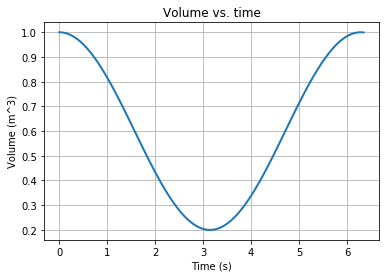

In [9]:
# plot the time evolution of volume
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['volume'], label='Volume',   lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Volume (m^3)',
       title ='Volume vs. time')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("V_vs_t_nonreacting.pdf")

The minimum volume is one-fifth of the inital volume, and the final volume is equal to the initial volume.

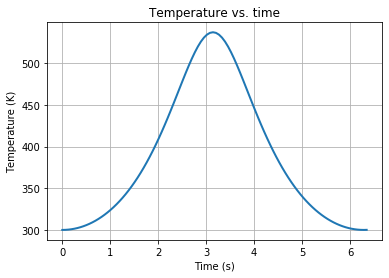

In [10]:
# plot the time evolution of temperature
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['temperature'], label='Temperature',   lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Temperature (K)',
       title ='Temperature vs. time')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_t_nonreacting.pdf")

The maximum temperature is not quite two times the inital temperature, and the system returns to the initial temperature when the volume returns to the initial volume. This suggests that negligible chemical reaction has occured.

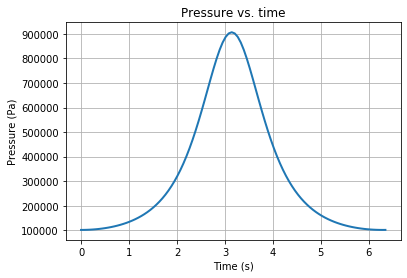

In [11]:
# plot the time evolution of pressure
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['pressure'], label='Pressure',   lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Pressure (Pa)',
       title ='Pressure vs. time')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("P_vs_t_nonreacting.pdf")

The maximum pressure is approximately nine times the inital pressure, and the system returns to the initial pressure when the volume returns to the initial volume. This again suggests that negligible chemical reaction has occured.

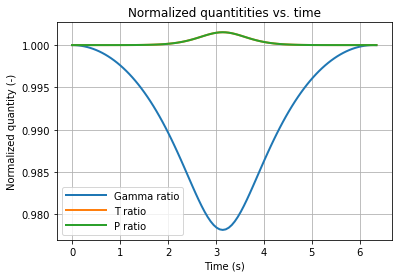

In [12]:
# plot the time evolution of gamma/gamma0, of T/Tisentropic, and of P/Pisentropic
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['gamma']/gamma0,                       label='Gamma ratio',   lw=2)
ax.plot(timeHistory.index, timeHistory['temperature']/timeHistory['T_isent'], label='T ratio',   lw=2)
ax.plot(timeHistory.index, timeHistory['pressure']/timeHistory['P_isent'],    label='P ratio',   lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Normalized quantity (-)',
       title ='Normalized quantitities vs. time')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Normalized_quantities_vs_t_nonreacting.pdf")

All three of these quantities would remain at constant values of unity, if the gas mixture in the reactor was a constant-property (constant value of $\gamma$) ideal gas undergoing an isentropic process.

At the time of minimum volume (maximum temperature and pressure), the value of $\gamma$ is approximately 2% lower than its initial and final value of $\gamma _ 0 $. The actual mixture temperature and pressure at all times are within 1% of the values corresponding to an isentropic constant-$\gamma$ process, when an average value of $\gamma$ is used for the purposes of the isentropic calculation.

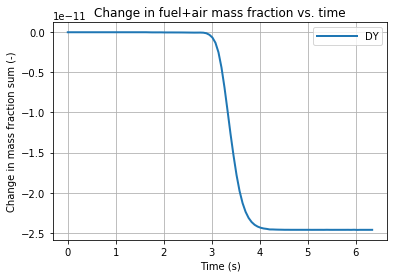

In [13]:
# plot the time evolution of the change in the sum of the mass fractions of n-heptane, O2, and N2
DY = ( timeHistory['nc7h16'] + timeHistory['o2'] + timeHistory['n2'] ) - 1.0
fig, ax = plt.subplots()
ax.plot(timeHistory.index, DY, label='DY', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Change in mass fraction sum (-)',
       title ='Change in fuel+air mass fraction vs. time')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("DY_vs_t_nonreacting.pdf")

This confirms that the composition remains essentially the same as the initial composition throughout the compression/expansion, to within 10 significant figures.

## 4. HCCI engine

Next we repeat the exercise for initial conditions and a time-varying volume for which autoignition occurs. Furthermore, we consider a system that has a time-varying volume that is representative of that in a single cylinder of an automotive-size piston engine: a right-circular cylinder volume with a diameter (the engine *bore* diameter $b$) of 86 mm, and a time-varying height that varies by 86 mm (the piston *stroke* $s$) over an engine cycle. The geometric *compression ratio* (the ratio of maximum volume to minimum volume, $CR$) is 10, and the *swept volume* or *displacement volume* (the difference between the maximum volume and the minimum volume, $V_{swept}$) is approximately 0.5 L (0.0005 m^3): $V_{swept} = \pi b ^2 s / 4$. We initialize the calculation with a fuel-lean fuel-air mixture at the maximum volume (assumed post-intake-valve closure conditions), and compute through one compression-expansion cycle (before exhaust-valve opening).

In engines, it is conventional to use crank-angle-degrees (CAD) of crankshaft rotation (denoted as $ \theta$) instead of time ($t$). Here we take $ \theta = 0 ^ {\circ} $ to correspond to the initial condition at time $ t = 0 $ (maximum volume, corresponding to the piston-bottom-dead-center position), and $\theta = 180 ^ {\circ} $ to correspond to the mimimum volume (piston-top-dead-center position). The relationship between crankangle $\theta$ in CAD and time $t$ in seconds is then:

$$ \theta = 6 \Omega_{CS} t $$

where $ \Omega_{CS} $ is the crankshaft rotational speed in revolutions per minute (r/min). At an engine speed of $ \Omega_{CS} =$ 1,200 r/min, one crankshaft revolution (360 CAD) requires 50 ms (0.05 s).

The relationship between piston position and $ \theta $ in a reciprocating-piston engine is given by the crank-slider equation. In the case where the connecting rod length is much larger than the stroke $s$, the piston motion can be approximated as simple harmonic motion. In that case, the piston speed $v$ in m/s as a function of crankangle degrees $ \theta$ is given by:

$$ v = s \pi \Omega _ {CS} \sin( \theta ) / 60 $$

For completeness, we start again from the beginning.

In [14]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import math

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [15]:
# define a gas mixture based on seiser.cti that corresponds to ambient air
ambair = ct.Solution('data/seiser.cti')

# specify the temperature, pressure, and composition
T_0 = 300.    # (K)
P_0 = 101325. # (Pa)
X_0 = {'o2':1.0, 'n2':3.76}

ambair.TPX = T_0, P_0, X_0



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


In [16]:
# define a gas mixture based on seiser.cti that corresponds to a n-heptane/air mixture
gas = ct.Solution('data/seiser.cti')

# set the mixture temperature to the reference temperature, to compute the formation enthalpies that we will
#   need to compute the heat-release rate - see tutorial Notebook 6_1_Ignition_delay
# only the mixture temperature matters here - not the mixture pressure or composition
gas.TP = 298.15 , None
hf     = gas.partial_molar_enthalpies



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


In [17]:
# define a function that returns the heat-release rate in W/m^3
# the gas mixture named "gas" must be defined on calling this function,
#   the species formation enthalpies for all species in "gas" must be available in the array "hf",
#   and the thermochemical state of "gas" (temperature, pressure, and composition) must be set to the
#   conditions at which the heat-release rate is to be computed
def heat_release_rate():
    qdot = 0.
    for i in range(gas.n_species):
        qdot += -gas.net_production_rates[i]*hf[i]
    return qdot

Next we define the engine geometry and operating condition.

In [18]:
# set engine geometric parameters
stroke = 0.086  # stroke (m)
bore   = 0.086  # bore (m)
CR     = 10.0   # geometric compression ratio

# compute derived geometric quantitites:
#   swept volume, maximum volume at piston bottom-dead-center (= initial volume), and piston area
Vswept = math.pi*bore*bore*stroke / 4.
V_0    = Vswept / ( 1. - 1./CR )
A_pist = math.pi*bore*bore / 4.

# set engine rotational speed
rpm    = 1200.  # engine speed (r/min)

# set initial thermochemical conditions at piston bottom-dead-center
# here a fuel-lean mixture of n-heptane and air is considered
T_0  = 350.       # (K)
P_0  = ct.one_atm # (Pa)
fuel = 'nc7h16'
air  = {'o2':1.0, 'n2':3.76}
phi  = 0.4

gas.TP = T_0, P_0
gas.set_equivalence_ratio(phi,fuel,air)

In [19]:
# define and name a reservoir that corresponds to ambient-temperature-and-pressure air as defined by "ambair"
# we would get the same results if we used a reactor here, rather than a reservoir
ambient_air = ct.Reservoir(contents=ambair,name="Ambient air reservoir")

# define and name a variable-volume reactor (the in-cylinder mixture) that is filled with the ideal-gas mixture "gas"
in_cylinder_mixture = ct.IdealGasReactor(contents=gas,name="Variable-volume batch reactor")

# set the initial reactor volume to the desired (piston-bottom-dead-center) value
in_cylinder_mixture.volume = V_0

# define and name an adiabatic wall between the reservoir and the reactor
# this wall corresponds to the moving piston
# the function "pvel" defines the piston velocity as a function of time - here a simple sinusoidal time variation
#   of volume is prescribed
# note that the argument of the "sin" function must be in radians
# the wall area is set to the piston cross-section area
pvel   = ct.Func1(lambda t: stroke*math.pi*rpm*math.sin(math.pi*rpm*t/30.)/60.)
piston = ct.Wall(left=ambient_air,right=in_cylinder_mixture,A=A_pist,velocity=pvel)

# add "in_cylinder_mixture" to a reactor network named "HCCI"
HCCI = ct.ReactorNet([in_cylinder_mixture])

# create a list of all variables (named "stateVariableNames") for which we will compute and store time-dependent data
# append two more, beyond those that are used internally as reactor state variables:
#   one for the reactor pressure
#   one for the heat-release rate - see tutorial Notebook 6.1_Ignition_delay
stateVariableNames = [in_cylinder_mixture.component_name(i) for i in range(in_cylinder_mixture.n_vars)]
stateVariableNames.append('pressure')
stateVariableNames.append('HRR')

# create a Pandas DataFrame named "timeHistory", using the extended list of state variable names as column headings
timeHistory = pd.DataFrame(columns=stateVariableNames)

# define an array to hold the additional variables desired at each time t
PHRR = np.zeros(2) # PHRR[0] is for pressure; PHRR[1] is for heat-release rate

In [20]:
# fill the first row of "timeHistory" with the initial condition
t                  = 0.
PHRR[0]            = gas.P
PHRR[1]            = heat_release_rate()
timeHistory.loc[t] = np.concatenate((in_cylinder_mixture.get_state(),PHRR))

timeHistory

,mass,volume,temperature,n2,ch3,h,ch4,h2,oh,h2o,...,nc7ket36,nc7ket42,nc7ket43,nc4h9coch2,c4h7ooh1-4,c5h9ooh1-4,c4h7o1-4,c5h9o1-4,pressure,HRR
0.0,0.000568,0.000555,350.0,0.747168,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101325.0,-1.976551e-18


Now perform the time integration. This will take several seconds, depending on your computer.

In [21]:
t_end   = 60./rpm      # end time for time integration (s), corresponding to one full crankshaft rotation
n_save  = 1000         # number of uniform time intervals at which the solution will be saved
dt_save = t_end/n_save # time interval at which the solution will be saved

# initialize the timer to monitor computer time required
ctim0 = time.time()

# perform the time integration, and save the state at the end of each time interval
# recall that "t" was initialized to zero earlier
while(t < t_end):
    t += dt_save
    HCCI.advance(t)
    PHRR[0] = gas.P
    PHRR[1] = heat_release_rate()
    timeHistory.loc[t] = np.concatenate((in_cylinder_mixture.get_state(),PHRR))
#    print(t,pvel(t),in_cylinder_mixture.volume)

# the computer time needed to perform the integration is the difference between ctim1 and ctim0
ctim1 = time.time()
ctime = ctim1 - ctim0

# print the computer time required
print('Compute time = {:.3e} s'.format(ctime))

Compute time = 7.764e+00 s


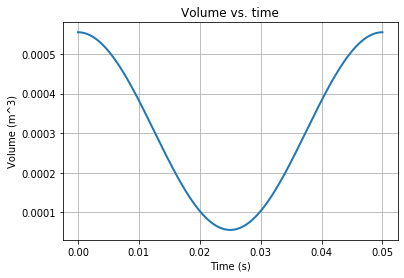

In [22]:
# plot the time evolution of volume
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['volume'], label='Volume',   lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Volume (m^3)',
       title ='Volume vs. time')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("V_vs_t_reacting.pdf")

The ratio of maximum volume to minimum volume is a factor of 10: the geometric compression ratio. Note that the minimum volume occurs at a time of 0.025 s, which corresponds to 180 CAD, or piston top-dead-center. 

It is more conventional in presenting piston-engine results to use crankangle degrees of rotation as the independent variable. We do that in the remaining figures, and also explicitly set the x-axis range from 0 to 360 CAD, with increments of 60 CAD.

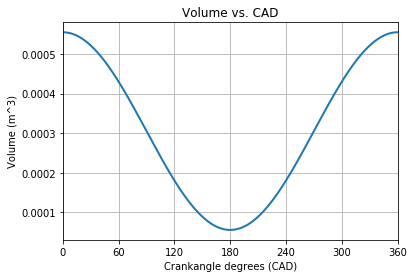

In [23]:
# plot the time (crankangle) evolution of volume
fig, ax = plt.subplots()
ax.plot(timeHistory.index*6.*rpm, timeHistory['volume'], label='Volume',   lw=2)
ax.set_xticks(np.arange(0.,361.,60.))
ax.set(xlim=(0.,360.),
       xlabel='Crankangle degrees (CAD)',
       ylabel='Volume (m^3)',
       title ='Volume vs. CAD')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("V_vs_CAD_reacting.pdf")

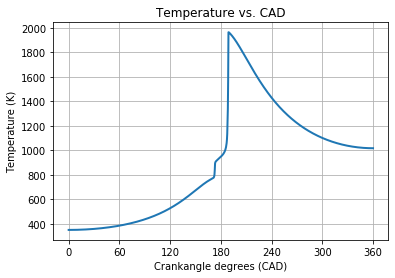

In [24]:
# plot the time (crankangle) evolution of temperature
fig, ax = plt.subplots()
ax.plot(timeHistory.index*6.*rpm, timeHistory['temperature'], label='Temperature',   lw=2)
ax.set_xticks(np.arange(0.,361.,60.))
ax.set(xlabel='Crankangle degrees (CAD)',
       ylabel='Temperature (K)',
       title ='Temperature vs. CAD')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_CAD_reacting.pdf")

In this case, autoignition occured. Note that the temperature increase occurs in two steps. For these conditions and this reaction mechanism, two-stage ignition is observed.

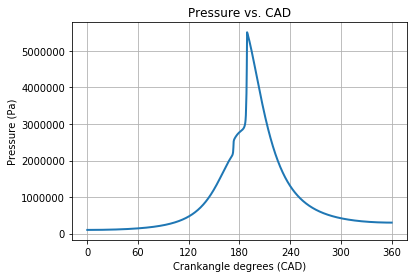

In [25]:
# plot the time (crankangle) evolution of pressure
fig, ax = plt.subplots()
ax.plot(timeHistory.index*6.*rpm, timeHistory['pressure'], label='Pressure',   lw=2)
ax.set_xticks(np.arange(0.,361.,60.))
ax.set(xlabel='Crankangle degrees (CAD)',
       ylabel='Pressure (Pa)',
       title ='Pressure vs. CAD')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("P_vs_CAD_reacting.pdf")

The two-stage nature of the ignition process is evident in the pressure trace. Let's look at the heat-release rate itself:

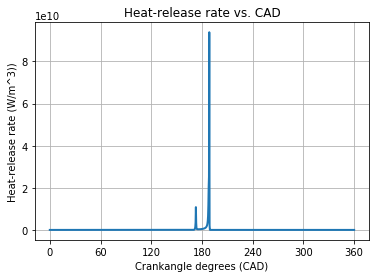

In [26]:
# plot the time (crankangle) evolution of heat-release rate
fig, ax = plt.subplots()
ax.plot(timeHistory.index*6.*rpm, timeHistory['HRR'], label='HRR',   lw=2)
ax.set_xticks(np.arange(0.,361.,60.))
ax.set(xlabel='Crankangle degrees (CAD)',
       ylabel='Heat-release rate (W/m^3))',
       title ='Heat-release rate vs. CAD')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("HRR_vs_CAD_reacting.pdf")

Again, two-stage ignition can be seen: an earlier weaker peak at a relatively low mixture temperature (see the temperature figure above) just before piston top-dead-center, and a later stronger peak at a higher mixture temperature just after piston top-dead-center. Different species and different chemical reactions are important in the first-stage (low-temperature) heat release versus the second-stage (high-temperature) heat release. Let's look at the time evolution of some of the key species:

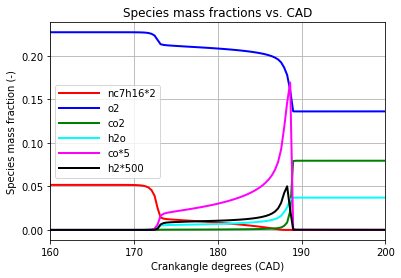

In [27]:
# plot the time (crankangle) evolution of major species, plus CO and H2, and zoom in around the time of interest
fig, ax = plt.subplots()
ax.plot(timeHistory.index*6.*rpm, timeHistory['nc7h16']*2., label='nc7h16*2', color='red',     lw=2)
ax.plot(timeHistory.index*6.*rpm, timeHistory['o2'],        label='o2',       color='blue',    lw=2)
ax.plot(timeHistory.index*6.*rpm, timeHistory['co2'],       label='co2',      color='green',   lw=2)
ax.plot(timeHistory.index*6.*rpm, timeHistory['h2o'],       label='h2o',      color='cyan',    lw=2)
ax.plot(timeHistory.index*6.*rpm, timeHistory['co']*5.,     label='co*5',     color='magenta', lw=2)
ax.plot(timeHistory.index*6.*rpm, timeHistory['h2']*500.,   label='h2*500',   color='black',   lw=2)
ax.set_xticks(np.arange(160.,201.,10.))
ax.set(xlim=(160.,200.),
       xlabel='Crankangle degrees (CAD)',
       ylabel='Species mass fraction (-)',
       title ='Species mass fractions vs. CAD')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Ymajor_vs_CAD_reacting.pdf")

Most of the fuel is consumed during the first-stage ignition, and essentially no fuel remains at the time of the second-stage ignition. The system is fuel-lean, so there is still significant O2 remaining after the reactions are essentially complete. CO and H2 appear after the first-stage ignition, and peak just before the second-stage ignition. Some H2O is formed between the first- and second-stage ignitions, but most H2O and CO2 are formed during the second-stage ignition.

Some of the key minor species are shown next.

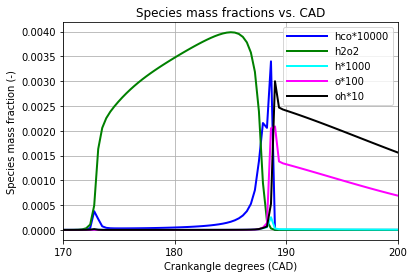

In [28]:
# plot the time (crankangle) evolution of some key minor species
fig, ax = plt.subplots()
ax.plot(timeHistory.index*6.*rpm, timeHistory['hco']*10000., label='hco*10000', color='blue',    lw=2)
ax.plot(timeHistory.index*6.*rpm, timeHistory['h2o2'],       label='h2o2',      color='green',   lw=2)
ax.plot(timeHistory.index*6.*rpm, timeHistory['h']*1000.,    label='h*1000',    color='cyan',    lw=2)
ax.plot(timeHistory.index*6.*rpm, timeHistory['o']*100.,     label='o*100',     color='magenta', lw=2)
ax.plot(timeHistory.index*6.*rpm, timeHistory['oh']*10.,     label='oh*10',     color='black',   lw=2)
ax.set_xticks(np.arange(170.,201.,10.))
ax.set(xlim=(170.,200.),
       xlabel='Crankangle degrees (CAD)',
       ylabel='Species mass fraction (-)',
       title ='Species mass fractions vs. CAD')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Yminor_vs_CAD_reacting.pdf")

Note the different scalings used for the different species.

Of these species, only HCO and H2O2 appear during the first-stage ignition, with the mass fraction of H2O2 being orders-of-magnitude higher than the mass fraction of HCO. H2O2 is a particularly important species in the autoignition process. The second-stage ignition occurs when H2O2 reaches a critical level, where it breaks down rapidly to form the smaller radicals that we have seen before: especially OH and O (and to a lesser extent, H).